# Benchmarking UniVI using CITE-seq data

Andrew Ashford, Pathways + Omics Group, Oregon Health & Science University - 11/18/2025

This Jupyter Notebook will be used to benchmark UniVI models trained using Hao CITE-seq human PBMC data.


#### Import modules

In [2]:
# 0. Imports
import os, sys, json
import numpy as np
import scanpy as sc
import torch

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

from univi import (
    UniVIMultiModalVAE,
    ModalityConfig,
    UniVIConfig,
    TrainingConfig,
    matching,
)
from univi.data import MultiModalDataset
from univi.trainer import UniVITrainer


#### Read in and preprocess data

In [3]:
# -------------------------
# 1. Load AnnData objects
# -------------------------
# Load RNA AnnData object
rna_adata = sc.read_h5ad("../data/Hao_CITE-seq_data/Hao_RNA_data.h5ad")



/home/groups/precepts/ashforda/anaconda3/envs/UniVI_working_environment_v2/lib/python3.8/site-packages/anndata/compat/__init__.py:229: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(


In [4]:
# Change the RNA counts to raw counts so they're not log-normalized and use ZINB or NB as the decoder distribution
# for model training
rna_adata.layers['log1p'] = rna_adata.X
rna_adata.X = rna_adata.raw.X


In [5]:
# If your counts are in rna_adata.X (raw or log-normalized), this is fine:
sc.pp.highly_variable_genes(
    rna_adata,
    layer='log1p',
    n_top_genes=2000,
    flavor="seurat",   # or "cell_ranger" / "seurat_v3"
    inplace=True,
)


In [6]:
# Boolean mask of HVGs
hvg_mask = rna_adata.var["highly_variable"].values

# Names of the top HVGs
hvg_genes = rna_adata.var_names[hvg_mask].tolist()
print(f"Selected {len(hvg_genes)} highly variable genes.")
print(hvg_genes[:20])  # peek at first few


Selected 2000 highly variable genes.
['HES4', 'ISG15', 'TNFRSF18', 'TNFRSF4', 'RBP7', 'EPHA2', 'PADI4', 'CDA', 'EIF4G3', 'AL031005.1', 'C1QA', 'C1QC', 'C1QB', 'TCEA3', 'ID3', 'RCAN3', 'LDLRAP1', 'STMN1', 'ZNF683', 'IFI6']


In [7]:
# Optional: make a HVG-only AnnData for modeling
rna_adata_hvg = rna_adata[:, hvg_mask].copy()
print(rna_adata_hvg)


AnnData object with n_obs × n_vars = 161764 × 2000
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'nCount_SCT', 'nFeature_SCT'
    var: 'features', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'neighbors', 'hvg'
    obsm: 'X_apca', 'X_aumap', 'X_pca', 'X_spca', 'X_umap', 'X_wnn.umap'
    varm: 'PCs', 'SPCA'
    layers: 'log1p'
    obsp: 'distances'


In [8]:
# Load ADT AnnData object
adt_adata = sc.read_h5ad("../data/Hao_CITE-seq_data/Hao_ADT_data.h5ad")


In [9]:
# Set the ADT data to raw counts and use a NB or ZINB decoder in model training and save the current .X counts to
# .layers['log1p']
adt_adata.layers['log1p'] = adt_adata.X
adt_adata.X = adt_adata.raw.X


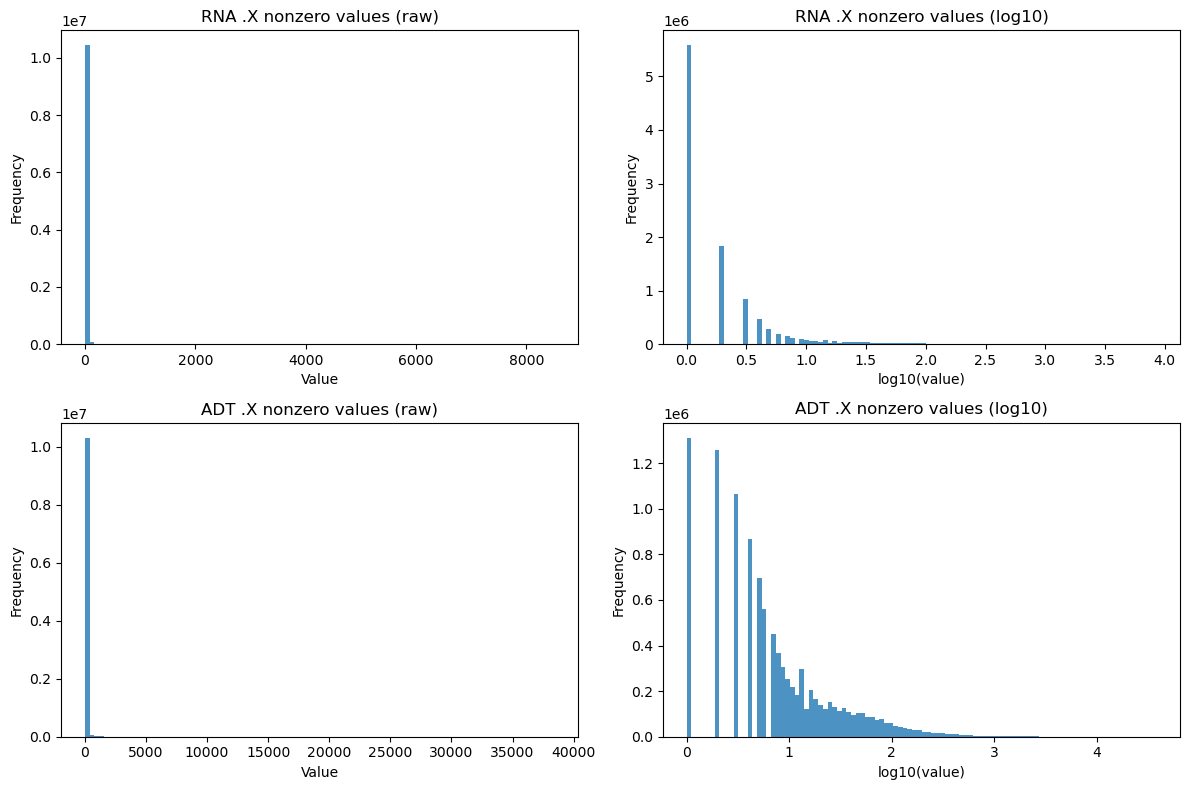

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse

def get_X_values(adata, n_cells: int = 5000):
    """
    Return flattened values from adata.X (optionally subsampled over cells).
    Uses only non-zero entries if X is sparse.
    """
    X = adata.X

    # Optional subsampling over cells (rows)
    if n_cells is not None and adata.n_obs > n_cells:
        idx = np.random.choice(adata.n_obs, size=n_cells, replace=False)
        X = X[idx]

    if sparse.issparse(X):
        vals = X.data  # nonzero values
    else:
        vals = np.asarray(X).ravel()

    # Remove zeros explicitly (just to focus on count/ADT magnitude)
    vals = vals[vals > 0]
    return vals

def plot_X_distribution(rna_adata, adt_adata, n_cells: int = 5000):
    rna_vals = get_X_values(rna_adata, n_cells=n_cells)
    adt_vals = get_X_values(adt_adata, n_cells=n_cells)

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    
    # --- RNA raw ---
    axes[0, 0].hist(rna_vals, bins=100, alpha=0.8)
    axes[0, 0].set_title("RNA .X nonzero values (raw)")
    axes[0, 0].set_xlabel("Value")
    axes[0, 0].set_ylabel("Frequency")

    # --- RNA log10 ---
    axes[0, 1].hist(np.log10(rna_vals + 1e-8), bins=100, alpha=0.8)
    axes[0, 1].set_title("RNA .X nonzero values (log10)")
    axes[0, 1].set_xlabel("log10(value)")
    axes[0, 1].set_ylabel("Frequency")

    # --- ADT raw ---
    axes[1, 0].hist(adt_vals, bins=100, alpha=0.8)
    axes[1, 0].set_title("ADT .X nonzero values (raw)")
    axes[1, 0].set_xlabel("Value")
    axes[1, 0].set_ylabel("Frequency")

    # --- ADT log10 ---
    axes[1, 1].hist(np.log10(adt_vals + 1e-8), bins=100, alpha=0.8)
    axes[1, 1].set_title("ADT .X nonzero values (log10)")
    axes[1, 1].set_xlabel("log10(value)")
    axes[1, 1].set_ylabel("Frequency")

    plt.tight_layout()
    plt.show()

# Call it:
plot_X_distribution(rna_adata_hvg, adt_adata, n_cells=50000)


In [11]:
print(rna_adata_hvg)
print(set(rna_adata_hvg.obs['celltype.l1']))
print(rna_adata_hvg.obs['celltype.l1'].value_counts())
print(set(rna_adata_hvg.obs['celltype.l2']))
print(rna_adata_hvg.obs['celltype.l2'].value_counts())
print(set(rna_adata_hvg.obs['celltype.l3']))
print(rna_adata_hvg.obs['celltype.l3'].value_counts())


AnnData object with n_obs × n_vars = 161764 × 2000
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'nCount_SCT', 'nFeature_SCT'
    var: 'features', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'neighbors', 'hvg'
    obsm: 'X_apca', 'X_aumap', 'X_pca', 'X_spca', 'X_umap', 'X_wnn.umap'
    varm: 'PCs', 'SPCA'
    layers: 'log1p'
    obsp: 'distances'
{'DC', 'other T', 'CD8 T', 'Mono', 'CD4 T', 'B', 'other', 'NK'}
Mono       49010
CD4 T      41001
CD8 T      25469
NK         18664
B          13800
other T     6789
DC          3589
other       3442
Name: celltype.l1, dtype: int64
{'NK_CD56bright', 'Plasmablast', 'Platelet', 'gdT', 'B memory', 'CD4 CTL', 'B intermediate', 'Treg', 'Eryth', 'CD4 TCM', 'ASDC', 'CD8 TEM', 'HSPC', 'CD8 Proliferating', 'CD8 TCM', 'pDC', 'CD4 Naive', 'CD4 Proliferating', 'CD8 Naive', 'CD16 Mono', 'NK Proliferating', 'cDC1', '

#### Specify any additional helper functions

In [12]:
def train_univi_model(
    rna_adata_hvg,
    adt_adata,
    train_cfg,
    likelihood_rna="nb",
    likelihood_adt="zinb",
    seed=0,
):
    torch.manual_seed(seed)
    np.random.seed(seed)

    modality_cfgs = [
        ModalityConfig(
            name="rna",
            input_dim=rna_adata_hvg.n_vars,
            encoder_hidden=[512, 256],
            decoder_hidden=[256, 512],
            likelihood=likelihood_rna,
        ),
        ModalityConfig(
            name="adt",
            input_dim=adt_adata.n_vars,
            encoder_hidden=[128, 64],
            decoder_hidden=[64, 128],
            likelihood=likelihood_adt,
        ),
    ]

    univi_cfg = UniVIConfig(
        latent_dim=40,
        modalities=modality_cfgs,
        beta=80.0,
        gamma=120.0,
        encoder_dropout=0.0,
        encoder_batchnorm=True,
        decoder_dropout=0.0,
        decoder_batchnorm=False,
        kl_anneal_start=0,
        kl_anneal_end=0,
        align_anneal_start=0,
        align_anneal_end=0,
    )

    model = UniVIMultiModalVAE(univi_cfg).to(train_cfg.device)

    trainer = UniVITrainer(
        model=model,
        train_loader=train_loader,  # from your earlier split code
        val_loader=val_loader,
        train_cfg=train_cfg,
        device=train_cfg.device,
    )

    history = trainer.fit()
    return model, trainer, history


#### Load data with data loaders for training/validation/test/unused sets

In [13]:
device = 'cpu'


In [14]:
train_cfg = TrainingConfig(
    n_epochs=200,
    batch_size=512,
    lr=1e-3,
    weight_decay=1e-4,
    device=device,
    log_every=10,
    grad_clip=5.0,
    num_workers=4,
    seed=42,
    early_stopping=True,
    patience=20,
    min_delta=0.0,
)


In [15]:
import numpy as np
import torch
from torch.utils.data import DataLoader, Subset
from univi.data import MultiModalDataset

# --------------------------------------------------
# 0. Sanity check: RNA / ADT are already aligned
# --------------------------------------------------
assert rna_adata_hvg.n_obs == adt_adata.n_obs, "RNA and ADT have different #cells"
assert np.array_equal(rna_adata_hvg.obs_names, adt_adata.obs_names), (
    "RNA and ADT obs_names are not aligned – align them first."
)

print(f"Total paired cells BEFORE subsampling: {rna_adata_hvg.n_obs}")

# --------------------------------------------------
# 1. Per-celltype subsampling for balance
# --------------------------------------------------
celltype_key = "celltype.l2"
max_per_type = 1000

labels = rna_adata_hvg.obs[celltype_key].astype(str).values
unique_ct = np.unique(labels)

rng = np.random.default_rng(train_cfg.seed)

selected_indices_list = []
for ct in unique_ct:
    idx_ct = np.where(labels == ct)[0]
    if len(idx_ct) == 0:
        continue
    if len(idx_ct) > max_per_type:
        chosen = rng.choice(idx_ct, size=max_per_type, replace=False)
    else:
        chosen = idx_ct
    selected_indices_list.append(chosen)

selected_indices = np.concatenate(selected_indices_list)
rng.shuffle(selected_indices)

n_cells = len(selected_indices)
print(f"Total paired cells AFTER per-celltype cap: {n_cells}")

# --------------------------------------------------
# 2. Build MultiModalDataset (full, indices will subset)
# --------------------------------------------------
adata_by_mod = {"rna": rna_adata_hvg, "adt": adt_adata}

full_dataset = MultiModalDataset(
    adata_dict=adata_by_mod,
    X_key="X",                # or your desired layer/key
    device=train_cfg.device,
)

# --------------------------------------------------
# 3. Train / val / test splits on selected_indices
# --------------------------------------------------
frac_train = 0.8
frac_val   = 0.1

n_train = int(frac_train * n_cells)
n_val   = int(frac_val   * n_cells)

train_idx = selected_indices[:n_train]
val_idx   = selected_indices[n_train:n_train + n_val]
test_idx  = selected_indices[n_train + n_val:]

print(f"Train: {len(train_idx)}, Val: {len(val_idx)}, Test: {len(test_idx)}")

train_dataset = Subset(full_dataset, train_idx)
val_dataset   = Subset(full_dataset, val_idx)
test_dataset  = Subset(full_dataset, test_idx)

train_loader = DataLoader(
    train_dataset,
    batch_size=train_cfg.batch_size,
    shuffle=True,
    num_workers=train_cfg.num_workers,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=train_cfg.batch_size,
    shuffle=False,
    num_workers=train_cfg.num_workers,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=train_cfg.batch_size,
    shuffle=False,
    num_workers=train_cfg.num_workers,
)

# --------------------------------------------------
# 4. Mark splits + unused cells for later reference
# --------------------------------------------------
def init_split_column(adata, col="univi_split"):
    if col not in adata.obs.columns:
        adata.obs[col] = "unused"

init_split_column(rna_adata, "univi_split")
init_split_column(adt_adata, "univi_split")

# start everything as unused
rna_adata.obs["univi_split"] = "unused"
adt_adata.obs["univi_split"] = "unused"

# mark train / val / test
rna_adata.obs.iloc[train_idx, rna_adata.obs.columns.get_loc("univi_split")] = "train"
rna_adata.obs.iloc[val_idx,   rna_adata.obs.columns.get_loc("univi_split")] = "val"
rna_adata.obs.iloc[test_idx,  rna_adata.obs.columns.get_loc("univi_split")] = "test"

adt_adata.obs.iloc[train_idx, adt_adata.obs.columns.get_loc("univi_split")] = "train"
adt_adata.obs.iloc[val_idx,   adt_adata.obs.columns.get_loc("univi_split")] = "val"
adt_adata.obs.iloc[test_idx,  adt_adata.obs.columns.get_loc("univi_split")] = "test"

rna_train_adata = rna_adata[rna_adata.obs["univi_split"] == "train"].copy()
rna_val_adata   = rna_adata[rna_adata.obs["univi_split"] == "val"].copy()
rna_test_adata  = rna_adata[rna_adata.obs["univi_split"] == "test"].copy()
rna_unused      = rna_adata[rna_adata.obs["univi_split"] == "unused"].copy()

adt_train_adata = adt_adata[adt_adata.obs["univi_split"] == "train"].copy()
adt_val_adata   = adt_adata[adt_adata.obs["univi_split"] == "val"].copy()
adt_test_adata  = adt_adata[adt_adata.obs["univi_split"] == "test"].copy()
adt_unused      = adt_adata[adt_adata.obs["univi_split"] == "unused"].copy()

print(
    "RNA split sizes:",
    {k: v.n_obs for k, v in dict(
        train=rna_train_adata,
        val=rna_val_adata,
        test=rna_test_adata,
        unused=rna_unused,
    ).items()},
)
print(
    "ADT split sizes:",
    {k: v.n_obs for k, v in dict(
        train=adt_train_adata,
        val=adt_val_adata,
        test=adt_test_adata,
        unused=adt_unused,
    ).items()},
)


Total paired cells BEFORE subsampling: 161764
Total paired cells AFTER per-celltype cap: 22649
Train: 18119, Val: 2264, Test: 2266
RNA split sizes: {'train': 18119, 'val': 2264, 'test': 2266, 'unused': 139115}
ADT split sizes: {'train': 18119, 'val': 2264, 'test': 2266, 'unused': 139115}


#### Set up model configs/loaders

In [ ]:
models = {}
histories = {}

for tag, (lik_rna, lik_adt) in {
    "gaussian": ("gaussian", "gaussian"),
    "nb":       ("nb",       "nb"),
    "zinb":     ("nb",       "zinb"),  # RNA NB, ADT ZINB
}.items():
    print(f"\n=== Training UniVI ({tag}) ===")
    model, trainer, history = train_univi_model(
        rna_adata_hvg,
        adt_adata,
        train_cfg,
        likelihood_rna=lik_rna,
        likelihood_adt=lik_adt,
        seed=42,
    )
    models[tag] = (model, trainer)
    histories[tag] = history



=== Training UniVI (gaussian) ===


[2025-11-18 17:46:22,241] [UniVITrainer] [INFO] TrainingConfig:
[2025-11-18 17:46:22,257] [UniVITrainer] [INFO]   n_epochs: 200
[2025-11-18 17:46:22,257] [UniVITrainer] [INFO]   batch_size: 512
[2025-11-18 17:46:22,258] [UniVITrainer] [INFO]   lr: 0.001
[2025-11-18 17:46:22,258] [UniVITrainer] [INFO]   weight_decay: 0.0001
[2025-11-18 17:46:22,259] [UniVITrainer] [INFO]   device: cpu
[2025-11-18 17:46:22,260] [UniVITrainer] [INFO]   log_every: 10
[2025-11-18 17:46:22,260] [UniVITrainer] [INFO]   grad_clip: 5.0
[2025-11-18 17:46:22,261] [UniVITrainer] [INFO]   num_workers: 4
[2025-11-18 17:46:22,261] [UniVITrainer] [INFO]   seed: 42
[2025-11-18 17:46:22,262] [UniVITrainer] [INFO]   early_stopping: True
[2025-11-18 17:46:22,263] [UniVITrainer] [INFO]   patience: 20
[2025-11-18 17:46:22,263] [UniVITrainer] [INFO]   min_delta: 0.0


Training UniVI:   0%|          | 0/200 [00:00<?, ?it/s]

[2025-11-18 17:53:31,661] [UniVITrainer] [INFO] [Epoch 001] Train loss: 4533699.8611 (beta=80.000, gamma=120.000)
[2025-11-18 17:54:02,777] [UniVITrainer] [INFO] [Epoch 001] Val loss: 3999420.2500 (beta=80.000, gamma=120.000)
[2025-11-18 17:54:02,840] [UniVITrainer] [INFO] [Epoch 001] New best val loss: 3999420.2500
[2025-11-18 18:03:31,221] [UniVITrainer] [INFO] [Epoch 002] New best val loss: 3026773.4000
[2025-11-18 18:11:22,318] [UniVITrainer] [INFO] [Epoch 003] New best val loss: 2451629.8500
[2025-11-18 18:19:56,827] [UniVITrainer] [INFO] [Epoch 004] New best val loss: 2345326.5500
[2025-11-18 18:28:02,917] [UniVITrainer] [INFO] [Epoch 005] New best val loss: 2255746.3250
[2025-11-18 18:37:23,969] [UniVITrainer] [INFO] [Epoch 006] New best val loss: 1919575.1500
[2025-11-18 18:46:32,464] [UniVITrainer] [INFO] [Epoch 007] New best val loss: 1565593.9250
[2025-11-18 18:54:56,966] [UniVITrainer] [INFO] [Epoch 008] New best val loss: 1420966.7750
[2025-11-18 19:03:08,443] [UniVITraine

[2025-11-19 03:03:35,839] [UniVITrainer] [INFO] [Epoch 090] Train loss: 300385.8151 (beta=80.000, gamma=120.000)
[2025-11-19 03:03:52,835] [UniVITrainer] [INFO] [Epoch 090] Val loss: 181361.7437 (beta=80.000, gamma=120.000)
[2025-11-19 03:03:52,950] [UniVITrainer] [INFO] [Epoch 090] New best val loss: 181361.7437
[2025-11-19 03:13:35,622] [UniVITrainer] [INFO] [Epoch 092] New best val loss: 176863.6375
[2025-11-19 03:25:26,194] [UniVITrainer] [INFO] [Epoch 095] New best val loss: 176575.5812
[2025-11-19 03:29:11,450] [UniVITrainer] [INFO] [Epoch 096] New best val loss: 176306.2781
[2025-11-19 03:42:09,742] [UniVITrainer] [INFO] [Epoch 099] New best val loss: 173405.0719
[2025-11-19 03:46:50,673] [UniVITrainer] [INFO] [Epoch 100] Train loss: 296530.9631 (beta=80.000, gamma=120.000)
[2025-11-19 03:47:07,552] [UniVITrainer] [INFO] [Epoch 100] Val loss: 179567.0250 (beta=80.000, gamma=120.000)
[2025-11-19 03:50:40,676] [UniVITrainer] [INFO] [Epoch 101] New best val loss: 172859.3438
[2025-


=== Training UniVI (nb) ===


Training UniVI:   0%|          | 0/200 [00:00<?, ?it/s]

[2025-11-19 06:27:33,773] [UniVITrainer] [INFO] [Epoch 001] Train loss: 4967.9705 (beta=80.000, gamma=120.000)
[2025-11-19 06:27:36,761] [UniVITrainer] [INFO] [Epoch 001] Val loss: 2518.9084 (beta=80.000, gamma=120.000)
[2025-11-19 06:27:36,766] [UniVITrainer] [INFO] [Epoch 001] New best val loss: 2518.9084
[2025-11-19 06:27:48,129] [UniVITrainer] [INFO] [Epoch 002] New best val loss: 1794.1826
[2025-11-19 06:27:59,372] [UniVITrainer] [INFO] [Epoch 003] New best val loss: 1674.7476
[2025-11-19 06:28:10,684] [UniVITrainer] [INFO] [Epoch 004] New best val loss: 1626.8135
[2025-11-19 06:28:21,886] [UniVITrainer] [INFO] [Epoch 005] New best val loss: 1611.1355
[2025-11-19 06:28:33,133] [UniVITrainer] [INFO] [Epoch 006] New best val loss: 1597.1507
[2025-11-19 06:28:44,433] [UniVITrainer] [INFO] [Epoch 007] New best val loss: 1586.7056
[2025-11-19 06:28:55,658] [UniVITrainer] [INFO] [Epoch 008] New best val loss: 1578.6624
[2025-11-19 06:29:06,715] [UniVITrainer] [INFO] [Epoch 009] New best

[2025-11-19 07:19:41,252] [UniVITrainer] [INFO] [Epoch 140] Val loss: 1457.1738 (beta=80.000, gamma=120.000)
[2025-11-19 07:22:09,413] [UniVITrainer] [INFO] [Epoch 145] New best val loss: 1454.5656
[2025-11-19 07:24:34,688] [UniVITrainer] [INFO] [Epoch 150] Train loss: 1468.6757 (beta=80.000, gamma=120.000)
[2025-11-19 07:24:37,806] [UniVITrainer] [INFO] [Epoch 150] Val loss: 1457.9668 (beta=80.000, gamma=120.000)
[2025-11-19 07:29:33,134] [UniVITrainer] [INFO] [Epoch 160] Train loss: 1467.8952 (beta=80.000, gamma=120.000)
[2025-11-19 07:29:36,409] [UniVITrainer] [INFO] [Epoch 160] Val loss: 1457.9863 (beta=80.000, gamma=120.000)
[2025-11-19 07:32:05,823] [UniVITrainer] [INFO] Early stopping at epoch 165 (best val loss = 1454.5656)
[2025-11-19 07:32:05,832] [UniVITrainer] [INFO] Restored best model from epoch 145 (val loss = 1454.5656)
[2025-11-19 07:32:05,860] [UniVITrainer] [INFO] TrainingConfig:
[2025-11-19 07:32:05,860] [UniVITrainer] [INFO]   n_epochs: 200
[2025-11-19 07:32:05,861


=== Training UniVI (zinb) ===


Training UniVI:   0%|          | 0/200 [00:00<?, ?it/s]

[2025-11-19 07:32:14,097] [UniVITrainer] [INFO] [Epoch 001] Train loss: 5099.9798 (beta=80.000, gamma=120.000)
[2025-11-19 07:32:17,229] [UniVITrainer] [INFO] [Epoch 001] Val loss: 2641.5582 (beta=80.000, gamma=120.000)
[2025-11-19 07:32:17,234] [UniVITrainer] [INFO] [Epoch 001] New best val loss: 2641.5582
[2025-11-19 07:32:28,754] [UniVITrainer] [INFO] [Epoch 002] New best val loss: 1910.9781
[2025-11-19 07:32:40,179] [UniVITrainer] [INFO] [Epoch 003] New best val loss: 1786.3101
[2025-11-19 07:32:51,474] [UniVITrainer] [INFO] [Epoch 004] New best val loss: 1733.9581
[2025-11-19 07:33:02,774] [UniVITrainer] [INFO] [Epoch 005] New best val loss: 1713.4069
[2025-11-19 07:33:14,309] [UniVITrainer] [INFO] [Epoch 006] New best val loss: 1695.9573
[2025-11-19 07:33:25,713] [UniVITrainer] [INFO] [Epoch 007] New best val loss: 1681.7292
[2025-11-19 07:33:37,218] [UniVITrainer] [INFO] [Epoch 008] New best val loss: 1670.8198
[2025-11-19 07:33:48,832] [UniVITrainer] [INFO] [Epoch 009] New best

[2025-11-19 08:22:02,573] [UniVITrainer] [INFO] [Epoch 110] Val loss: 1469.2903 (beta=80.000, gamma=120.000)
[2025-11-19 08:22:02,581] [UniVITrainer] [INFO] [Epoch 110] New best val loss: 1469.2903
[2025-11-19 08:23:01,876] [UniVITrainer] [INFO] [Epoch 112] New best val loss: 1467.8465
[2025-11-19 08:23:31,317] [UniVITrainer] [INFO] [Epoch 113] New best val loss: 1467.0413
[2025-11-19 08:25:30,185] [UniVITrainer] [INFO] [Epoch 117] New best val loss: 1466.9196
[2025-11-19 08:25:59,924] [UniVITrainer] [INFO] [Epoch 118] New best val loss: 1465.6605
[2025-11-19 08:26:56,671] [UniVITrainer] [INFO] [Epoch 120] Train loss: 1477.9663 (beta=80.000, gamma=120.000)
[2025-11-19 08:26:59,823] [UniVITrainer] [INFO] [Epoch 120] Val loss: 1467.7647 (beta=80.000, gamma=120.000)
[2025-11-19 08:32:14,099] [UniVITrainer] [INFO] [Epoch 124] New best val loss: 1464.7875
[2025-11-19 08:36:46,682] [UniVITrainer] [INFO] [Epoch 125] New best val loss: 1464.1799
[2025-11-19 08:49:03,593] [UniVITrainer] [INFO] 

In [ ]:
torch.save(model.state_dict(), f"univi_{tag}_benchmarking_best.pt")


#### Evaluation on test set

In [ ]:
import scipy.sparse as sp

def encode_full_latents(model, trainer, rna_adata, adt_adata, batch_size=1024):
    model.eval()
    device = trainer.device

    def _encode(adata, modality):
        X = adata.X
        if sp.issparse(X):
            X = X.toarray()
        X_t = torch.as_tensor(X, dtype=torch.float32, device=device)

        zs = []
        for start in range(0, X_t.shape[0], batch_size):
            xb = X_t[start:start+batch_size]
            mu_dict, logvar_dict = model.encode_modalities({modality: xb})
            mu_z, logvar_z = model.mixture_of_experts(
                {modality: mu_dict[modality]},
                {modality: logvar_dict[modality]},
            )
            zs.append(mu_z.detach().cpu().numpy())
        return np.vstack(zs)

    z_rna = _encode(rna_adata, "rna")
    z_adt = _encode(adt_adata, "adt")
    return z_rna, z_adt


In [ ]:
from univi import evaluation as univi_eval
from univi import plotting as univi_plot

results = []

for tag, (model, trainer) in models.items():
    print(f"\n=== Eval: {tag} ===")

    # 1. Latents
    z_rna, z_adt = encode_full_latents(model, trainer, rna_test_adata, adt_test_adata)

    # 2. FOSCTTM
    fos = univi_eval.compute_foscttm(z_rna, z_adt)
    print(f"FOSCTTM: {fos:.4f}")

    # 3. Modality mixing
    Z_joint = np.concatenate([z_rna, z_adt], axis=0)
    mods = np.array(["rna"] * z_rna.shape[0] + ["adt"] * z_adt.shape[0])
    mix = univi_eval.compute_modality_mixing(Z_joint, mods, k=20)
    print(f"Mixing score (k=20): {mix:.3f}")

    # 4. Label transfer (ADT → RNA on test)
    labels_rna = rna_test_adata.obs["celltype.l2"].astype(str).values
    labels_adt = adt_test_adata.obs["celltype.l2"].astype(str).values

    pred_rna_from_adt, acc_rna, cm_rna = univi_eval.label_transfer_knn(
        Z_source=z_adt,
        labels_source=labels_adt,
        Z_target=z_rna,
        labels_target=labels_rna,
        k=15,
    )
    print(f"Label transfer acc (ADT→RNA, test, k=15): {acc_rna:.3f}")

    # 5. Cross-modal reconstruction: RNA→ADT (test set)
    model.eval()
    with torch.no_grad():
        X_rna = rna_test_adata.X
        if sp.issparse(X_rna):
            X_rna = X_rna.toarray()
        X_rna_t = torch.as_tensor(X_rna, dtype=torch.float32, device=trainer.device)

        xhat_adt_list = []
        bs = 512
        for start in range(0, X_rna_t.shape[0], bs):
            xb = X_rna_t[start:start+bs]
            mu_dict, logvar_dict = model.encode_modalities({"rna": xb})
            mu_z, logvar_z = model.mixture_of_experts(
                {"rna": mu_dict["rna"]},
                {"rna": logvar_dict["rna"]},
            )
            xhat_raw = model.decode_modalities(mu_z)
            xhat_adt_list.append(xhat_raw["adt"].cpu().numpy())

        xhat_adt = np.vstack(xhat_adt_list)

    X_adt = adt_test_adata.X
    if sp.issparse(X_adt):
        X_adt = X_adt.toarray()

    mse_feat = univi_eval.mse_per_feature(X_adt, xhat_adt)
    corr_feat = univi_eval.pearson_corr_per_feature(X_adt, xhat_adt)

    print(f"ADT MSE (RNA→ADT, test): {mse_feat.mean():.4f}")
    print(f"ADT Pearson r (RNA→ADT, test): {corr_feat.mean():.3f}")

    results.append({
        "model": tag,
        "foscttm": float(fos),
        "mixing": float(mix),
        "label_acc": float(acc_rna),
        "adt_mse": float(mse_feat.mean()),
        "adt_corr": float(corr_feat.mean()),
    })


In [ ]:
import pandas as pd
results_df = pd.DataFrame(results)
results_df
